In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re

In [13]:
df = pd.read_csv('./data/hackathon_income_train.csv', delimiter=';', on_bad_lines='skip')
print(df['dt'].head())

def dt_to_days_from_2024(val):
    if pd.isna(val):
        return pd.NA
    s = str(val).strip()
    # допускаем разделители '-', '.', '_' или пробел
    parts = re.split(r'[-._\s]', s)
    if len(parts) != 3:
        # финальный fallback: позволим pandas распарсить любой понятный формат
        dt = pd.to_datetime(s, errors='coerce')
        return pd.NA if pd.isna(dt) else (dt.date() - datetime.date(2024, 1, 1)).days
    try:
        y, w, d = [int(x) for x in parts]
    except Exception:
        dt = pd.to_datetime(s, errors='coerce')
        return pd.NA if pd.isna(dt) else (dt.date() - datetime.date(2024, 1, 1)).days

    # пытаемся трактовать как ISO year-week-day (д: 1..7)
    try:
        date = datetime.date.fromisocalendar(y, w, d)
    except Exception:
        # если не ISO, пробуем как год-месяц-день
        try:
            date = datetime.date(y, w, d)
        except Exception:
            dt = pd.to_datetime(s, errors='coerce')
            if pd.isna(dt):
                return pd.NA
            date = dt.date()

    base = datetime.date(2024, 1, 1)
    return (date - base).days

# Перезаписываем колонку 'dt' количеством дней от 2024-01-01
df['dt'] = df['dt'].apply(dt_to_days_from_2024).astype('Int64')

print(df[['dt']].head())
print(df.info())

0    2024-04-30
1    2024-02-29
2    2024-02-29
3    2024-04-30
4    2024-04-30
Name: dt, dtype: object
    dt
0  120
1   59
2   59
3  120
4  120
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76786 entries, 0 to 76785
Columns: 224 entries, id to first_salary_income
dtypes: Int64(1), float64(34), int64(1), object(188)
memory usage: 131.3+ MB
None


In [14]:
na_counts = {}
notna_counts = {}
for column in df.columns:
    na_count = df[column].isna().sum()
    na_percentage = (na_count / len(df)) * 100
    na_counts[column] = na_percentage
    notna_counts[column] = 100 - na_percentage
print(na_counts.values())
list_na_counts = [[k, v] for k, v in na_counts.items() if v > 0]
df_na_counts = pd.DataFrame(list_na_counts, columns=['feature', 'na_percentage'])
df_na_counts.to_csv('./data/na_counts.csv', index=False)

dict_values([np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(23.061495585132707), np.float64(80.62797905868257), np.float64(12.206652254317193), np.float64(78.50780090120595), np.float64(17.90039851014508), np.float64(16.889797619357697), np.float64(0.0), np.float64(21.582059229547053), np.float64(25.47730054957935), np.float64(22.600474044747738), np.float64(22.600474044747738), np.float64(19.25481207511786), np.float64(0.0), np.float64(79.25923996561873), np.float64(22.600474044747738), np.float64(58.65913057067694), np.float64(22.600474044747738), np.float64(23.71005131143698), np.float64(78.76956736905166), np.float64(23.443075560649078), np.float64(22.600474044747738), np.float64(61.0163311020238), np.float64(78.50780090120595), np.float64(21.582059229547053), np.float64(25.94222905217097), np.float64(16.889797619357697), np.float64(45.44969134998568), np.float64(21.582059229547053), np.float64(79.368634907405), np.float64(49.6587919672857), np.float64(22.60047404474

In [15]:
import numpy as np

for column in df.select_dtypes(include=['object']).columns:
    codes = df[column].astype('category').cat.codes
    codes = codes.replace(-1, np.nan) 
    df[column] = codes.fillna(codes.mean())
print(df.info())
df.to_csv('./data/hackathon_income_train_cleared.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76786 entries, 0 to 76785
Columns: 224 entries, id to first_salary_income
dtypes: Int64(1), float64(217), int32(2), int64(1), int8(3)
memory usage: 129.2 MB
None


avg_by_category__amount__sum__cashflowcategory_name__reklama_v_internete               0.001359
days_after_last_request                                                               -0.001343
ovrd_sum                                                                              -0.001303
loan_cnt                                                                              -0.001240
transaction_category_supermarket_sum_cnt_m2                                            0.001229
hdb_bki_total_cc_max_overdue                                                           0.001159
by_category__amount__sum__eoperation_type_name__perevod_mezhdu_svoimi_schetami        -0.000714
avg_by_category__amount__sum__cashflowcategory_name__kosmetika                        -0.000687
transaction_category_supermarket_sum_cnt_m3_4                                         -0.000591
by_category__amount__sum__eoperation_type_name__platezh_za_mobilnyj_cherez_ps         -0.000552
calledCtnOutGroup                       

/home/votter/projects/Hackaton-Alfa/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/votter/projects/Hackaton-Alfa/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


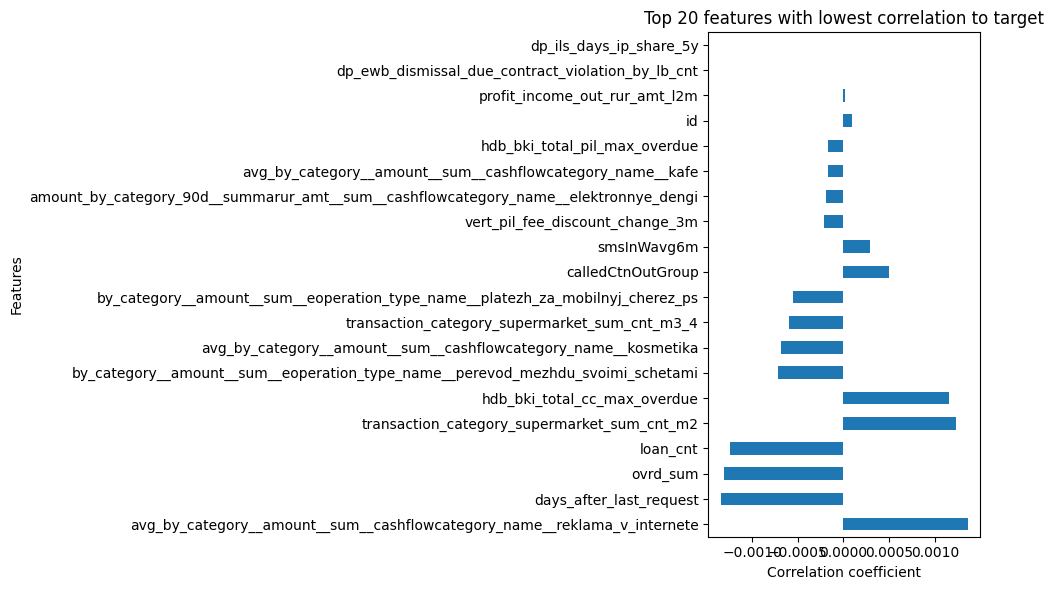

In [16]:
import pandas as pd

target = "target"
num_cols = df.select_dtypes(include="number").columns.drop(target)

corr = {col: df[target].corr(df[col]) for col in num_cols}
corr = pd.Series(corr).sort_values(key=lambda s: s.abs(), ascending=False)
print(corr[-20:])
plt.figure(figsize=(10, 6))
corr[-20:].plot.barh()
plt.title("Top 20 features with lowest correlation to target")
plt.xlabel("Correlation coefficient")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [17]:
notna_counts20 = {}
for column in na_counts.keys():
    if notna_counts[column] < 20:
        #print("Feature: ", column, ", NaN percentage: ", notna_counts[column], "%", ", Correlation: ", corr[column], sep='')
        notna_counts20[column] = [notna_counts[column], corr[column]]
notna_counts20 = sorted(notna_counts20.items(), key=lambda item: item[1][1])
for item in notna_counts20:
    if (abs(item[1][1]) < 1.0 / 224):    
        print(item[0])

avg_balance_rur_amt_1m_af
by_category__amount__sum__eoperation_type_name__perevod_s_karty_na_kartu
avg_by_category__amount__sum__cashflowcategory_name__platezhi_cherez_internet
avg_by_category__amount__sum__cashflowcategory_name__oteli
avg_by_category__amount__sum__cashflowcategory_name__set_supermarketov
turn_fdep_db_avg_v2
calledCtnOutGroup
avg_by_category__amount__sum__cashflowcategory_name__reklama_v_internete
avg_by_category__amount__sum__cashflowcategory_name__zarubezhnye_finansovye_operatsii
loan_cur_amt


avg_balance_rur_amt_1m_af
by_category__amount__sum__eoperation_type_name__perevod_s_karty_na_kartu
avg_by_category__amount__sum__cashflowcategory_name__platezhi_cherez_internet
avg_by_category__amount__sum__cashflowcategory_name__oteli
avg_by_category__amount__sum__cashflowcategory_name__set_supermarketov
turn_fdep_db_avg_v2
calledCtnOutGroup
avg_by_category__amount__sum__cashflowcategory_name__reklama_v_internete
avg_by_category__amount__sum__cashflowcategory_name__zarubezhnye_finansovye_operatsii
loan_cur_amt

w                                          -0.714320
salary_6to12m_avg                           0.321425
dp_ils_avg_salary_1y                        0.180013
dp_ils_avg_salary_2y                        0.168458
dp_payoutincomedata_payout_avg_6_month      0.166910
dp_ils_paymentssum_avg_12m                 -0.163463
dp_ils_paymentssum_avg_6m                  -0.149474
dp_ils_paymentssum_avg_6m_current          -0.149340
dp_ils_avg_salary_3y                        0.137838
dp_payoutincomedata_payout_avg_3_month      0.136078
dp_ils_accpayment_month_avg                -0.119856
dp_payoutincomedata_payout_avg_prev_year    0.104110
dp_ils_accpayment_avg_12m                  -0.100595
hdb_bki_active_cc_max_limit                -0.089166
bki_total_il_max_limit                     -0.087348
hdb_bki_total_ip_max_limit                 -0.087052
dp_ils_accpayment_avg_6m_current           -0.086287
dp_ils_accpayment_avg_6m                   -0.086087
incomeValueCategory                        -0.

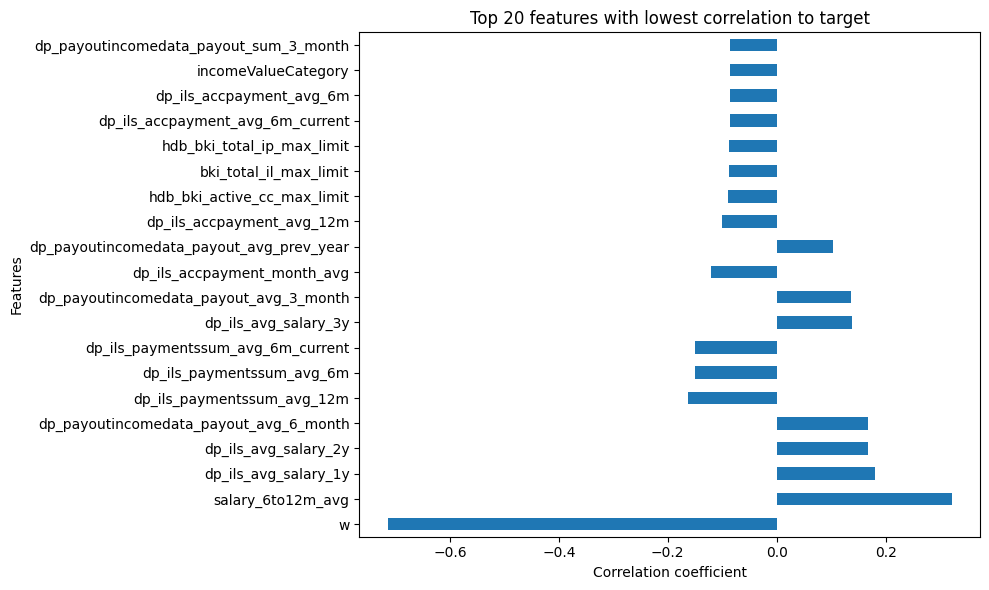

In [18]:
print(corr[:20])
plt.figure(figsize=(10, 6))
corr[:20].plot.barh()
plt.title("Top 20 features with lowest correlation to target")
plt.xlabel("Correlation coefficient")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [19]:
def detect_feature_type(s: pd.Series, binary_threshold=2, cat_threshold=20):
    if s.name == 'dt':
        return "numeric"
    if pd.api.types.is_bool_dtype(s):
        return "binary"
    if pd.api.types.is_numeric_dtype(s):
        uniq = s.nunique(dropna=True)
        if uniq <= binary_threshold:
            return "binary"
        # если немного значений, трактуем как категорию, иначе числовой
        return "categorical" if uniq <= cat_threshold else "numeric"
    # всё остальное считаем категориальным
    return "categorical"

types = {col: detect_feature_type(df[col]) for col in df.columns}
categorial_features = [col for col, t in types.items() if t == "categorical"]
numeric_features = [col for col, t in types.items() if t == "numeric"]
binary_features = [col for col, t in types.items() if t == "binary"]
print("Categorical features:", categorial_features)
print("Numeric features:", numeric_features)
print("Binary features:", binary_features)

Categorical features: ['incomeValueCategory', 'pil', 'bki_total_auto_cnt', 'blacklist_flag', 'loan_cnt', 'hdb_bki_total_ip_cnt', 'acard', 'tz_msk_timedelta', 'winback_cnt', 'vert_has_app_ru_tinkoff_investing', 'vert_pil_sms_success_3m', 'bki_total_products', 'dp_ils_cnt_changes_1y', 'dp_ils_employeers_cnt_last_month', 'bki_active_auto_cnt', 'client_active_flag', 'vert_has_app_ru_vtb_invest', 'vert_has_app_ru_cian_main', 'vert_has_app_ru_raiffeisennews', 'bki_total_active_products', 'vert_pil_loan_application_success_3m', 'businessTelSubs', 'accountsalary_out_flag', 'dp_ils_uniq_companies_1y']
Numeric features: ['id', 'dt', 'target', 'turn_cur_cr_avg_act_v2', 'salary_6to12m_avg', 'hdb_bki_total_max_limit', 'dp_ils_paymentssum_avg_12m', 'hdb_bki_total_cc_max_limit', 'incomeValue', 'avg_cur_cr_turn', 'adminarea', 'turn_cur_cr_avg_v2', 'turn_cur_cr_max_v2', 'hdb_bki_total_pil_max_limit', 'age', 'dp_ils_avg_salary_1y', 'turn_cur_cr_sum_v2', 'by_category__amount__sum__eoperation_type_name__i

Смотрим общее количество значений в датасете, если булевая переменная, то так и ставим, если имеет большие числа, чем то, ставим либо числовой либо категориальный, в зависимости от того сколько уникальных значений

In [20]:
import pandas as pd
import numpy as np
from pandas.api import types as ptypes

def detect_feature_type(s: pd.Series, binary_threshold=2, cat_threshold=20):
    # явно считаем колонку dt числовой
    if s.name == 'dt':
        return "numeric"
    if ptypes.is_bool_dtype(s):
        return "binary"
    if ptypes.is_numeric_dtype(s):
        uniq = s.nunique(dropna=True)
        if uniq <= binary_threshold:
            return "binary"
        return "categorical" if uniq <= cat_threshold else "numeric"
    return "categorical"

def impute_df(df: pd.DataFrame):
    df_imputed = df.copy()
    fill_stats = {}
    orig_dtypes = df.dtypes.to_dict()

    for col in df_imputed.columns:
        ftype = detect_feature_type(df_imputed[col])

        if ftype == "numeric":
            fill_value = df_imputed[col].median(skipna=True)
            # если медиана не определена (все NaN), подставим 0
            if pd.isna(fill_value):
                fill_value = 0
            df_imputed[col] = df_imputed[col].fillna(fill_value)
        elif ftype == "binary":
            mode = df_imputed[col].mode(dropna=True)
            fill_value = mode.iloc[0] if not mode.empty else 0
            df_imputed[col] = df_imputed[col].fillna(fill_value)
        else:  # categorical
            mode = df_imputed[col].mode(dropna=True)
            fill_value = mode.iloc[0] if not mode.empty else "missing"
            df_imputed[col] = df_imputed[col].fillna(fill_value)

        # попытка вернуть исходный dtype (например nullable Int64)
        orig_dtype = orig_dtypes[col]
        try:
            df_imputed[col] = df_imputed[col].astype(orig_dtype)
        except Exception:
            # если не удалось — оставляем текущий тип
            pass

        fill_stats[col] = fill_value

    return df_imputed, fill_stats

# Заполняем все NaN и перезаписываем df
df, fill_stats = impute_df(df)

print("Imputation statistics:")
for col, val in fill_stats.items():
    print(f"Column: {col}, Fill value: {val}")
    

Imputation statistics:
Column: id, Fill value: 74975.5
Column: dt, Fill value: 120.0
Column: target, Fill value: 36514.5
Column: turn_cur_cr_avg_act_v2, Fill value: 27441.00077863164
Column: salary_6to12m_avg, Fill value: 7437.0
Column: hdb_bki_total_max_limit, Fill value: 577200.0
Column: dp_ils_paymentssum_avg_12m, Fill value: 8251.0
Column: hdb_bki_total_cc_max_limit, Fill value: 155000.0
Column: incomeValue, Fill value: 25983.27948665716
Column: gender, Fill value: 1
Column: avg_cur_cr_turn, Fill value: 20985.29697412562
Column: adminarea, Fill value: 50.73646960138406
Column: turn_cur_cr_avg_v2, Fill value: 27645.932140934176
Column: turn_cur_cr_max_v2, Fill value: 16935.277409476377
Column: hdb_bki_total_pil_max_limit, Fill value: 338977.5
Column: age, Fill value: 22.0
Column: dp_ils_avg_salary_1y, Fill value: 7762.591422830592
Column: turn_cur_cr_sum_v2, Fill value: 27309.761694036883
Column: by_category__amount__sum__eoperation_type_name__ishodjaschij_bystryj_platezh_sbp, Fill 

In [21]:
df.to_csv('./data/hackathon_income_train_imputed.csv', index=False)